# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's import our resources and download the Fashion-MNIST dataset from `tensorflow_datasets`. 

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.13.0
	• GPU device not found. Running on CPU


## Load the Dataset

We are now going to load the Fashion-MNIST dataset using `tensorflow_datasets` as we've done before. In this case, however, we are going to omit the `split` argument.  This means that `tensorflow_datasets` will use the default value for `split` which is `split=None`. When `split=None`, `tensorflow_datasets` returns a **dictionary** with all the splits available for the dataset you are loading. However, if the split is given explicitly, such as `split='train'`, then `tensorflow_datasets` returns a `tf.data.Dataset` object.

In our case, we are going to load the `fashion_mnist` dataset. If we look at the [documentation](https://www.tensorflow.org/datasets/catalog/fashion_mnist#statistics) we will see that this particular dataset has 2 splits, namely a `train` and a `test` slipt. We also see that the `train` split has 60,000 examples, and that the `test` split has 10,000 examples. 

Now, let's load the `fashion_mnist` dataset and inspect the returned values.

In [5]:
dataset, dataset_info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)

Dataset fashion_mnist downloaded and prepared to C:\Users\Daniel\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
# Check that dataset is a dictionary
print('dataset has type:', type(dataset))

# Print the keys of the dataset dictionary
print('\nThe keys of dataset are:', list(dataset.keys()))

dataset has type: <class 'dict'>

The keys of dataset are: [Split('train'), Split('test')]


In the cell below, we are going to save the training data and the test data into different variables.

In [7]:
training_set, test_set = dataset['train'], dataset['test']

Now, let's take a look at the `dataset_info`

In [8]:
# Display the dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\Daniel\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
 

We can access the information in `dataset_info` very easily. As we can see, the `features` and `splits` info are contained in dictionaries. We can access the information we want by accessing the particular key and value in these dictionaries. We start by looking at the values of particular keys in these dictionaries:

In [9]:
dataset_info.features['image']

Image(shape=(28, 28, 1), dtype=uint8)

In [10]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=10)

In [11]:
dataset_info.splits['train']

<SplitInfo num_examples=60000, num_shards=1>

We can now use dot notation to access the information we want. Below are some examples. 

In [12]:
shape_images = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes

num_training_examples  = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print('There are {:,} classes in our dataset'.format(num_classes))
print('The images in our dataset have shape:', shape_images)

print('\nThere are {:,} images in the test set'.format(num_test_examples))
print('There are {:,} images in the training set'.format(num_training_examples))

There are 10 classes in our dataset
The images in our dataset have shape: (28, 28, 1)

There are 10,000 images in the test set
There are 60,000 images in the training set


## Explore the Dataset

The images in this dataset are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, we create them here to use later when plotting the images:

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [14]:
for image, label in training_set.take(1):
    print('The images in the training set have:\n\u2022 dtype:', image.dtype, '\n\u2022 shape:', image.shape)

The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (28, 28, 1)


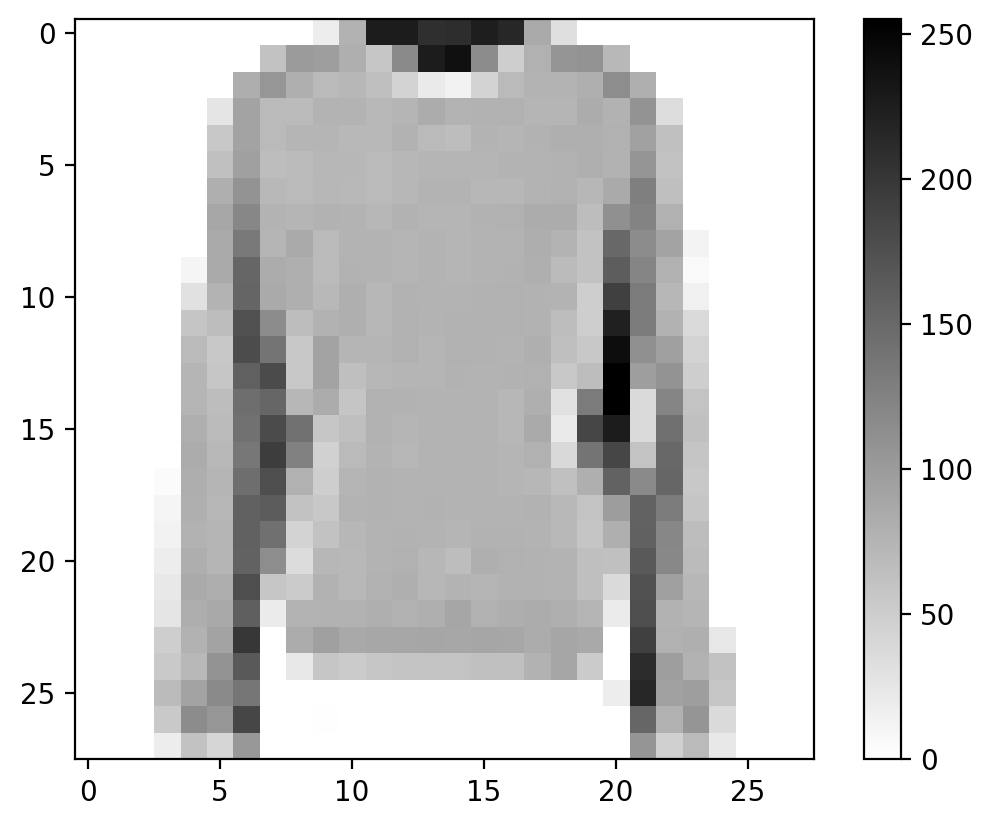

The label of this image is: 2
The class name of this image is: Pullover


In [15]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

## Create Pipeline

In [16]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the Model

> **Exercise:** Here you should define your own neural network. Feel free to create a model with as many layers and neurons as you like. You should keep in mind that as with MNIST, each image is 28 $\times$ 28 which is a total of 784 pixels, and there are 10 classes. Your model should include at least one hidden layer. We suggest you use ReLU activation functions for the hidden layers and a softmax activation function for the output layer.

In [21]:
## Solution
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28, 28, 1)),
        tf.keras.layers.Dense(255, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

## Train the Model

> **Exercise:** Compile the model you created above using an `adam` optimizer, a `sparse_categorical_crossentropy` loss function, and the `accuracy` metric. Then train the model for 5 epochs. You should be able to get the training loss below 0.4.

In [22]:
## Solution
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


EPOCHS = 5

history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/5


938/938 [==============================] - 3s 3ms/step - loss: 0.4933 - accuracy: 0.8243
Epoch 2/5
938/938 [==============================] - 2s 3ms/step - loss: 0.3648 - accuracy: 0.8658
Epoch 3/5
938/938 [==============================] - 2s 3ms/step - loss: 0.3295 - accuracy: 0.8789
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.3065 - accuracy: 0.8866
Epoch 5/5
938/938 [==============================] - 2s 3ms/step - loss: 0.2879 - accuracy: 0.8918


## Evaluate Loss and Accuracy on the Test Set

Now let's see how the model performs on the test set. This time, we will use all the examples in our test set to assess the loss and accuracy of our model. Remember, the images in the test are images the model has never seen before.

In [23]:
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

157/157 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8770

Loss on the TEST Set: 0.342
Accuracy on the TEST Set: 87.700%


## Check Predictions

2/2 [==============================] - 0s 5ms/step


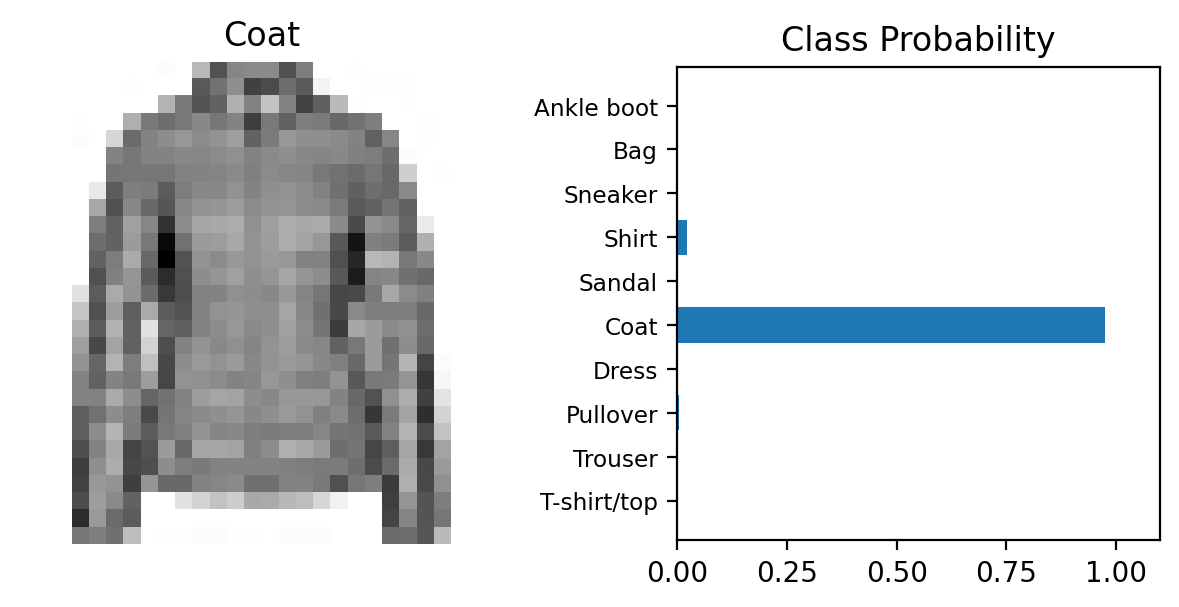

In [24]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    first_label = label_batch.numpy()[0]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax1.set_title(class_names[first_label])
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(class_names, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()